# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [2]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [3]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    plt.savefig("exlettre.png")
    return

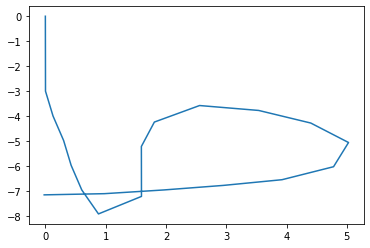

In [4]:
tracerLettre(X[12])

In [5]:
Y[12]

'b'

##  Apprentissage d'un modèle CM (max de vraisemblance)
### 1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats`
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [6]:
def discretise(x, d):
    inervalle = 360 / d
    result = None
    try:
        result = np.floor(x / inervalle) 
    
    except TypeError as error:
        print(x)
    return result

In [7]:
discretise(X[0],3)

array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.])

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### 2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [8]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe 

### 3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [9]:
def learnMarkovModel(Xc, d):
    
    A = np.zeros((d, d))
    Pi = np.zeros(d)
    
    for i in range(len(Xc)):
        Pi[int(Xc[i][0])] += 1
        for j in range(len(Xc[i]) -1 ):
            A[int(Xc[i][j])][int(Xc[i][j+1])] +=1   
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
    Pi = Pi / Pi.sum()
    return Pi, A

In [10]:
a = np.array([ discretise(X[i],3)  for i in groupByLabel(Y)[0]])
print(learnMarkovModel(a,3))
a=None

(array([0.36363636, 0.        , 0.63636364]), array([[0.84444444, 0.06666667, 0.08888889],
       [0.        , 0.83333333, 0.16666667],
       [0.11382114, 0.06504065, 0.82113821]]))


**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

### 4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [11]:
def get_models(d):
    Xd = np.array([discretise(x, d) for x in X ])    # application de la discrétisation
    index = groupByLabel(Y)  # groupement des signaux par classe
    models = []
    for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
        models.append(learnMarkovModel(Xd[index[cl]], d))
    return models,Xd

##  Test (affectation dans les classes sur critère MV)
### 1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [12]:
def probaSequence(s, Pi, A):
    if(s[0]-int(s[0]) >0):
        raise TypeError(type(s[0]))    
    ml = np.log(Pi[int(s[0])])
    for i in range(1,len(s)):
        ml += np.log(A[ int(s[i-1])][int(s[i])])
    return ml
models,_ = get_models(3)
np.array([probaSequence(discretise(X[0],3),m[0],m[1]) for m in models ]) 

/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])

**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

On ne peut pas dire a ce que le signaleil est bien classé ou pas car on a beaucoup d'erreur a cause des probabilite a zéro dans la matrice p0 et meme dans la matrie de transition ce qui nos donne les -inf cat le log(0) est -inf 

### 2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [13]:
# avec une discretisation sur 20 états
models,Xd = get_models(20)
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [14]:
models,Xd = get_models(3)
proba3 = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


### 3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [15]:
#avec une discretisation à 20 état
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

0.914179104477612

In [16]:
#avec une discretisation à 3 état
# Calcul de la classe la plus probable :
pred = proba3.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

0.6902985074626866

**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [17]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [18]:
itrain

[array([ 9, 10,  7,  3,  6,  4,  5,  2]),
 array([13, 16, 11, 14, 18, 17, 15, 12]),
 array([26, 32, 28, 30, 29, 22, 24, 27]),
 array([34, 35, 38, 42, 41, 40, 39, 33]),
 array([44, 48, 52, 54, 49, 53, 45, 47]),
 array([57, 61, 59, 64, 62, 56, 58, 60]),
 array([72, 76, 69, 71, 68, 75, 74, 70]),
 array([82, 79, 87, 86, 83, 84, 81, 85]),
 array([91, 96, 90, 88, 92, 89, 94, 93]),
 array([107, 102, 105, 100,  99, 103, 101, 104]),
 array([117, 108, 110, 111, 113, 116, 114, 109]),
 array([123, 120, 118, 125, 124, 126, 119, 127]),
 array([137, 132, 131, 136, 129, 135, 128, 134]),
 array([139, 138, 147, 144, 142, 145, 146, 141]),
 array([148, 156, 153, 149, 152, 151, 155, 150]),
 array([166, 158, 163, 164, 160, 159, 167, 165]),
 array([175, 169, 173, 172, 170, 174, 171, 176]),
 array([183, 187, 179, 184, 181, 186, 182, 178]),
 array([194, 196, 189, 190, 192, 197, 191, 188]),
 array([201, 200, 203, 198, 206, 199, 207, 204]),
 array([208, 213, 209, 214, 216, 217, 210, 212]),
 array([226, 224, 218,

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [19]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

In [20]:
def train(itrain,d):
    ia = []
    for i in itrain:
        ia += i.tolist()    
    classes = 26
    Xd_train = np.array([discretise(x, d) \
                   for cl in range(0,classes) for x in X[itrain[cl]]  ])
    
    index = groupByLabel(Y[ia]) 
    models = []
    for cl in range(len(np.unique(Y[ia]))): 
        models.append(learnMarkovModel(Xd_train[index[cl]], d))
    return models

def test(itest,models,d):
    classes=26
    it = []
    for i in itest:
        it += i.tolist()
    Xd_test = np.array([discretise(x, d) for cl in range(0,classes) for x in X[itest[cl]]  ])
    proba = np.array([[probaSequence(Xd_test[i], models[cl][0], models[cl][1]) for i in range(len(Xd_test))]
                  for cl in range(classes)])
    pred = proba.argmax(0)
    return pred,Ynum[it]

def getAccuracy(d,itrain,itest):
    models = train(itrain,d)
    pred,y = test(itest,models,d)
    res = np.where(pred != y , 0.,1.).mean()
    return res

def cross_validation_accuracy(d,_it=10,p=None):
    import random
    if( p is None):
        p=random.uniform(0.5, 0.9)
    accuracies = np.zeros(_it+1)
    for itiration in range(0,_it):
        itrain, itest = separeTrainTest(Y, p)
        acc = getAccuracy(d,itrain,itest)
        accuracies[itiration] = acc
    return  accuracies.mean()


/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


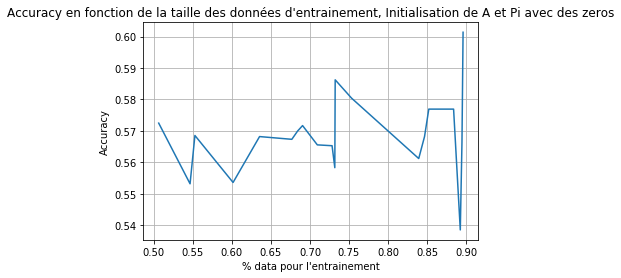

In [21]:
import random
x = np.array([ random.uniform(0.5, 0.9) for i in range(0,20)])
x.sort()
y = np.array([ cross_validation_accuracy(3,10,x[i]) for i in range(0,20)]) 
plt.xlabel('% data pour l\'entrainement')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de la taille des données d\'entrainement, Initialisation de A et Pi avec des zeros')
plt.grid(True)
plt.plot(x,y)
plt.show()

/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


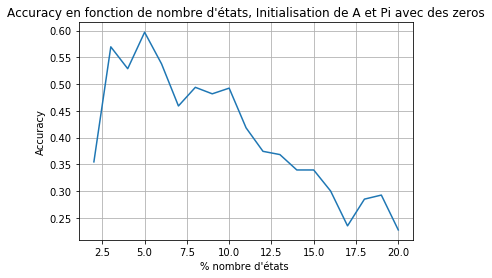

In [22]:
import matplotlib.pyplot as plt

x = np.arange(19)+2
y = np.array([ cross_validation_accuracy(i,10,0.8) for i in range(2,21)]) 
plt.xlabel('% nombre d\'états ')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de nombre d\'états, Initialisation de A et Pi avec des zeros')
plt.grid(True)
plt.plot(x,y)
plt.show()

## Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [23]:
def _learnMarkovModel(Xc, d):
    
    A = np.ones((d, d))
    Pi = np.ones(d)
    
    for i in range(len(Xc)):
        Pi[int(Xc[i][0])] += 1
        for j in range(len(Xc[i]) -1 ):
            A[int(Xc[i][j])][int(Xc[i][j+1])] +=1   
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
    Pi = Pi / Pi.sum()
    return Pi, A

def _train(itrain,d):
    ia = []
    for i in itrain:
        ia += i.tolist()    
    classes = 26
    Xd_train = np.array([discretise(x, d) \
                   for cl in range(0,classes) for x in X[itrain[cl]]  ])
    
    index = groupByLabel(Y[ia]) 
    models = []
    for cl in range(len(np.unique(Y[ia]))): 
        models.append(_learnMarkovModel(Xd_train[index[cl]], d))
    return models


def _getAccuracy(d,itrain,itest):
    models = _train(itrain,d)
    pred,y = test(itest,models,d)
    res = np.where(pred != y , 0.,1.).mean()
    return res

def _cross_validation_accuracy(d,_it=10,p=None):
    import random
    if( p is None):
        p=random.uniform(0.5, 0.9)
    accuracies = np.zeros(_it+1)
    for itiration in range(0,_it):
        itrain, itest = separeTrainTest(Y, p)
        acc = _getAccuracy(d,itrain,itest)
        accuracies[itiration] = acc
    return  accuracies.mean()


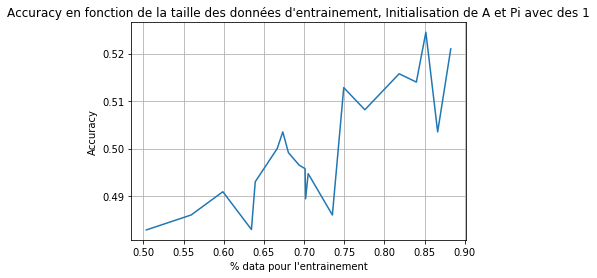

In [24]:
x = np.array([ random.uniform(0.5, 0.9) for i in range(0,20)])
x.sort()
y = np.array([ _cross_validation_accuracy(3,10,x[i]) for i in range(0,20)]) 
plt.xlabel('% data pour l\'entrainement')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de la taille des données d\'entrainement, Initialisation de A et Pi avec des 1')
plt.grid(True)
plt.plot(x,y)
plt.show()


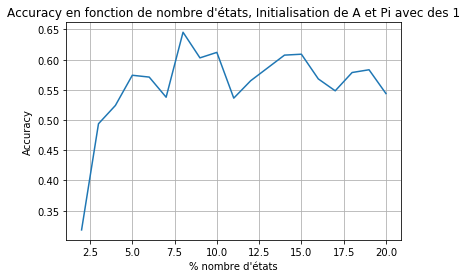

In [25]:
x = np.arange(19)+2
y = np.array([ _cross_validation_accuracy(i,10,0.8) for i in range(2,21)]) 
plt.xlabel('% nombre d\'états')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de nombre d\'états, Initialisation de A et Pi avec des 1')
plt.grid(True)
plt.plot(x,y)
plt.show()

# Partie optionnelle
## Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [26]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [73]:
d = 7
itrain, itest = separeTrainTest(Y, 0.9)
models = train(itrain,d)
pred,y = test(itest,models,d)

for i in range(0,26):
        conf[int(pred[i])][int(y[i])] += 1  


/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/ghiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


- Tracé de la matrice : 

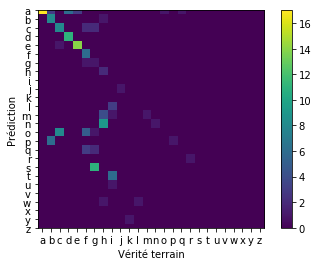

In [74]:
plt.figure()
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
plt.savefig("mat_conf_lettres.png")

## Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [77]:
# Votre code
def generate(Pi,A,N):
    r = random.random()
    e = np.where(Pi.cumsum() > r )[0][0]
    etats = [e]
    for i in range(1,N):
        r = random.random()
        e = np.where(A[etats[i-1]].cumsum() > r )[0][0]
        etats.append(e)
    return etats
models = train(itrain,3)

### Affichage du résultat

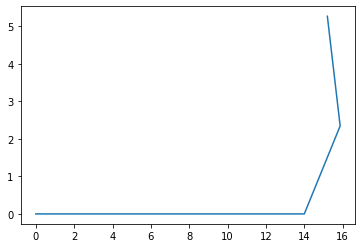

In [78]:
newa = generate(models[0][0], models[0][1], 20)       # generation d'une séquence d'états
intervalle = 360. / d                                 # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
tracerLettre(newa_continu)